## Libraries and Data

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')


warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
# Auxiliary Functions

# Calculate the proportion

def calculate_prop(data, column):
    '''
    Calcula a proporcao para as variaveis categoricas.


    '''
    tmp = data[column].value_counts().reset_index(name='amount')
    tmp['prop'] = tmp['amount'] / tmp['amount'].sum() * 100
    return tmp



# Relabeling the data

def relabel_sentiments(sentiment):
    '''
    Criar uma nova classificacao para os tweets.
    '''

    positive = ['Positive', 'Happiness', 'Joy', 'Love', 'Amusement', 'Enjoyment', 'Admiration', 'Affection', 'Awe', 'Surprise', 
                'Acceptance', 'Adoration', 'Anticipation', 'Excitement', 'Kindness', 'Pride', 'Elation', 'Euphoria', 
                'Contentment', 'Serenity', 'Gratitude', 'Hope', 'Empowerment', 'Compassion', 'Tenderness', 'Arousal', 
                'Enthusiasm', 'Fulfillment', 'Reverence', 'Determination', 'Zest', 'Hopeful', 'Proud', 'Grateful', 
                'Empathetic', 'Compassionate', 'Playful', 'Free-spirited', 'Inspired', 'Confident', 'Inspiration', 
                'Motivation', 'Joyful', 'Satisfaction', 'Blessed', 'Accomplishment', 'Optimism', 'Elation', 'Wonder', 
                'Radiance', 'Rejuvenation', 'Cozy', 'Adventure', 'Melodic', 'Festive', 'Freedom', 'Dazzle', 'Artistic', 
                'Culinary', 'Marvel', 'Spark', 'Thrill', 'Harmony', 'Creativity', 'Reflective', 'Awe', 'Amazement', 
                'Romance', 'Captivation', 'Tranquility', 'Grandeur', 'Emotion', 'Energy', 'Celebration', 'Charm', 
                'Ecstasy', 'Connection', 'Iconic', 'Journey', 'Engagement', 'Touched', 'Triumph', 'Heartwarming', 
                'Enchantment', 'Exploration', 'Success']
    
    negative = ['Negative', 'Anger', 'Fear', 'Sadness', 'Disgust', 'Disappointed', 'Bitter', 'Confusion', 'Shame', 
                'Despair', 'Grief', 'Loneliness', 'Jealousy', 'Resentment', 'Frustration', 'Boredom', 'Anxiety', 
                'Intimidation', 'Helplessness', 'Envy', 'Melancholy', 'Ambivalence', 'Yearning', 'Fearful', 'Apprehensive', 
                'Overwhelmed', 'Devastated', 'Dismissive', 'Bittersweet', 'Disappointment', 'Regret', 'Suffering', 
                'Isolation', 'LostLove', 'Exhaustion', 'Sorrow', 'Darkness', 'Desperation', 'Ruins', 'Desolation', 
                'Betrayal', 'Heartache', 'Solitude', 'Heartbreak', 'Hate', 'Bad', 'Miscalculation', 'Challenge', 
                'Obstacle', 'Sympathy', 'Pressure']
    
    neutral = ['Neutral', 'Calmness', 'Numbness', 'Reflection', 'Contemplation', 'Serenity', 'Mindfulness', 'Pensive', 
               'Acceptance', 'Indifference', 'Relief']
    
    sentiment = sentiment.strip()
    if sentiment in positive:
        return 'Positive'
    elif sentiment in negative:
        return 'Negative'
    elif sentiment in neutral:
        return 'Neutral'
    else:
        return 'Other'
    


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean(text):
    ''' 
    Limpeza e padronizacao do texto
    '''
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text) # remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Replace newlines with space
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and strip leading/trailing spaces
    
    tokens = word_tokenize(text)
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text



def test_means_difference(data, value_col, group_col):
    """
    Testa se as médias de diferentes grupos são significativamente diferentes.
    
    Args:
    data (pd.DataFrame): DataFrame contendo os dados.
    value_col (str): Nome da coluna com os valores a serem testados.
    group_col (str): Nome da coluna com os grupos.
    
    Returns:
    dict: Dicionário com os resultados do teste.
    """
    # Testar a normalidade dos dados
    grouped = data.groupby(group_col)[value_col]
    normality_p_values = {group: stats.shapiro(values)[1] for group, values in grouped}

    # Verificar se todos os grupos são normais
    all_normal = all(p > 0.05 for p in normality_p_values.values())

    print("Normalidade dos dados:")
    for group, p_value in normality_p_values.items():
        print(f"{group}: p-value = {p_value:.4f}")

    if all_normal:
        # Dados normais, usar ANOVA
        groups = [values for name, values in grouped]
        f_val, p_val = stats.f_oneway(*groups)
        test_name = 'ANOVA'
    else:
        # Dados não normais, usar Kruskal-Wallis
        groups = [values for name, values in grouped]
        f_val, p_val = stats.kruskal(*groups)
        test_name = 'Kruskal-Wallis'

    print(f"\nResultado do teste ({test_name}):")
    print(f"Estatística do teste: {f_val:.4f}")
    print(f"p-valor: {p_val:.4f}")

    conclusion = "As médias dos grupos são significativamente diferentes." if p_val < 0.05 else "Não há diferença significativa entre as médias dos grupos."

    print("Conclusão:", conclusion)

    return {
        "test_name": test_name,
        "test_statistic": f_val,
        "p_value": p_val,
        "conclusion": conclusion
    }



In [2]:
# Data

data = pd.read_csv('DATA/sentimentdataset.csv')

## Data Understanding

In [4]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [6]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.')

The data has 732 rows and 15 columns.


In [7]:
data.isna().sum()

Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64

In [9]:
# Checking the unique values
data_unique = data.nunique().reset_index(name = 'col')
data_unique['prop'] = data_unique['col']/data.shape[0]*100
data_unique

,index,col,prop
0,Unnamed: 0.1,732,100.000000
1,Unnamed: 0,732,100.000000
2,Text,707,96.584699
3,Sentiment,279,38.114754
4,Timestamp,683,93.306011
5,User,685,93.579235
6,Platform,4,0.546448
7,Hashtags,697,95.218579
8,Retweets,26,3.551913
9,Likes,38,5.191257


- The first two columns are likely an ID or a position code. I will drop them.
- The 'Text' column shows that we have 3-4% of duplicate messages.
- There are 279 class for the sentiment.

In [12]:
# Removing the Unnamed columns

col_names = data.columns
col_names = [col for col in col_names if col not in ['Unnamed: 0.1', 'Unnamed: 0']]

data_tmp = data[col_names].copy()

In [13]:
data_tmp.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [14]:
# Removing the duplicated rows

data_tmp.drop_duplicates()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,Collaborating on a science project that receiv...,Happy,2017-08-18 18:20:00,ScienceProjectSuccessHighSchool,Facebook,#ScienceFairWinner #HighSchoolScience,20.0,39.0,UK,2017,8,18,18
728,Attending a surprise birthday party organized ...,Happy,2018-06-22 14:15:00,BirthdayPartyJoyHighSchool,Instagram,#SurpriseCelebration #HighSchoolFriendship,25.0,48.0,USA,2018,6,22,14
729,Successfully fundraising for a school charity ...,Happy,2019-04-05 17:30:00,CharityFundraisingTriumphHighSchool,Twitter,#CommunityGiving #HighSchoolPhilanthropy,22.0,42.0,Canada,2019,4,5,17
730,"Participating in a multicultural festival, cel...",Happy,2020-02-29 20:45:00,MulticulturalFestivalJoyHighSchool,Facebook,#CulturalCelebration #HighSchoolUnity,21.0,43.0,UK,2020,2,29,20


# Exploratory Data Analysis

## Univariate Analysis

In [18]:
# Column: Sentiment

calculate_prop(data_tmp, 'Sentiment')

,Sentiment,amount,prop
0,Positive,44,6.010929
1,Joy,42,5.737705
2,Excitement,32,4.371585
3,Neutral,14,1.912568
4,Contentment,14,1.912568
...,...,...,...
274,Adrenaline,1,0.136612
275,Harmony,1,0.136612
276,ArtisticBurst,1,0.136612
277,Radiance,1,0.136612


In [19]:
data_tmp['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

- There are so many labels in the 'Sentiment' (280 labels) column that I decided to relabel the information into 3/4 classes.
- Relabeling this information into fewer classes can help simplify the analysis and make it more manageable.
- For the relabeling, I decided to create the groups myself, but it is important to mention that there are some libraries that analyze the data and classify it into groups, like `nltk`.

In [26]:
# Applying the relabeling

data_tmp['Relabeled_Sentiment'] = data_tmp['Sentiment'].apply(relabel_sentiments)
sentiment_table = data_tmp['Relabeled_Sentiment'].value_counts().reset_index(name = 'count')
sentiment_table['prop'] = round(sentiment_table['count']/sentiment_table['count'].sum() * 100,2)
sentiment_table

,Relabeled_Sentiment,count,prop
0,Positive,401,54.78
1,Negative,163,22.27
2,Other,125,17.08
3,Neutral,43,5.87


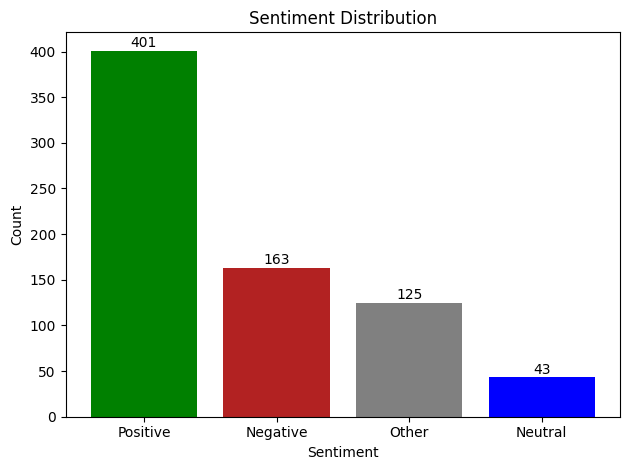

In [23]:
# Plotting the groups

colors = {
    'Positive' : 'green',
    'Negative' : 'firebrick',
    'Neutral' : 'blue',
    'Other' : 'grey'
}

plt.bar(sentiment_table['Relabeled_Sentiment'], sentiment_table['count'],
        color = [colors[label] for label in sentiment_table['Relabeled_Sentiment']]
        )

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

for i, count in enumerate(sentiment_table['count']):
    plt.text(i, count + 1, str(count), ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()

- The most number of tweets are positive (55%), followed by negative (22%) and others (17%).
- These classes are unbalanced.

In [27]:
# Timestamp
data_tmp['Timestamp'] = pd.to_datetime(data_tmp['Timestamp'])
data_tmp['Timestamp'].describe()

count                              732
mean     2020-12-08 21:37:38.196721408
min                2010-05-15 15:30:00
25%                2019-03-08 17:27:30
50%                2021-09-20 14:30:00
75%                2023-02-26 11:48:45
max                2023-10-22 20:45:00
Name: Timestamp, dtype: object

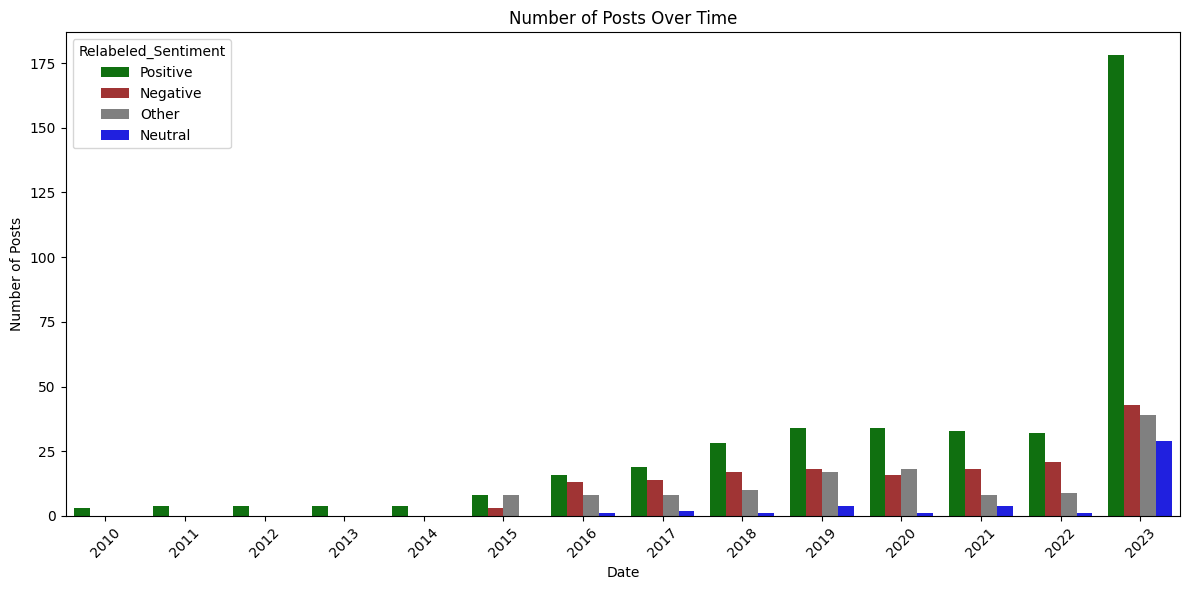

In [44]:
# Year 

# Plotting the time series
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Year', hue = 'Relabeled_Sentiment', data = data_tmp, palette=colors)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Number of Posts Over Time')

# Rotating date labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [29]:
res_year = data_tmp['Year'].value_counts().reset_index(name = 'count')
res_year['prop'] = res_year['count']/res_year['count'].sum() * 100
res_year.sort_values('Year')

,Year,count,prop
13,2010,3,0.409836
9,2011,4,0.546448
10,2012,4,0.546448
11,2013,4,0.546448
12,2014,4,0.546448
8,2015,19,2.595628
7,2016,38,5.191257
6,2017,43,5.874317
5,2018,56,7.650273
1,2019,73,9.972678


In [34]:
print(f" There are {len(data_tmp[data_tmp['Year'] < 2015])} tweets before 2015")

 There are 19 tweets before 2015


- The data is from 2010 to 2023.
- 40% of the tweets are from the year 2023.
- Initially, I won't consider this variable Year.

In [35]:
# Users
print(f"There are {data_tmp['User'].nunique()} unique users and it represents {round(data_tmp['User'].nunique()/data_tmp['User'].shape[0]*100,2)}%.")

There are 685 unique users and it represents 93.58%.


In [37]:
users_qtde = data_tmp['User'].value_counts().reset_index(name = 'count')
users_qtde['prop'] = users_qtde['count']/users_qtde['count'].sum()*100
users_qtde.sort_values('count', ascending = False)
users_qtde.describe()

,count,prop
count,685.000000,685.000000
mean,1.068613,0.145985
std,0.285557,0.039010
min,1.000000,0.136612
25%,1.000000,0.136612
50%,1.000000,0.136612
75%,1.000000,0.136612
max,3.000000,0.409836


- 75% of the users have just one tweet.
- The mean is 1.06 and the standard deviation is 0.28.

In [38]:
# Platform

calculate_prop(data_tmp, 'Platform')

,Platform,amount,prop
0,Instagram,258,35.245902
1,Facebook,231,31.557377
2,Twitter,128,17.486339
3,Twitter,115,15.710383


In [39]:
# Adjusting the words
data_tmp['Platform'] = data_tmp['Platform'].str.strip().replace('Twitter', 'Twitter')

In [40]:
calculate_prop(data_tmp, 'Platform')

,Platform,amount,prop
0,Instagram,258,35.245902
1,Twitter,243,33.196721
2,Facebook,231,31.557377


In [93]:
# Hashtags

hashtags = data_tmp['Hashtags'].reset_index()
hashtags = hashtags['Hashtags'].str.split(expand = True)
hashtags.columns = ['col1', 'col2']
stacked_hashtags = hashtags.stack().reset_index(level=1, drop=True).reset_index(name='Hashtag')
stacked_hashtags

,index,Hashtag
0,0,nature
1,0,park
2,1,traffic
3,1,morning
4,2,fitness
...,...,...
1459,729,highschoolphilanthropy
1460,730,culturalcelebration
1461,730,highschoolunity
1462,731,virtualentertainment


In [94]:
# How many different hashtags?

print(f" There are {stacked_hashtags['Hashtag'].nunique()} different hastags")

 There are 975 different hastags


In [95]:
data_tmp['Hashtags'] = data_tmp['Hashtags'].str.replace(r'#', '', regex = True)
data_tmp['Hashtags'] = data_tmp['Hashtags'].str.lower()

In [97]:
calculate_prop(stacked_hashtags, 'Hashtag')

,Hashtag,amount,prop
0,serenity,15,1.024590
1,excitement,13,0.887978
2,gratitude,13,0.887978
3,despair,11,0.751366
4,nostalgia,11,0.751366
...,...,...,...
970,culturalexperience,1,0.068306
971,confidence,1,0.068306
972,overcominganxiety,1,0.068306
973,fitnesssuccess,1,0.068306


In [48]:
# Countries

countries = calculate_prop(data_tmp, 'Country')
countries

,Country,amount,prop
0,USA,59,8.060109
1,USA,55,7.513661
2,UK,49,6.693989
3,Canada,44,6.010929
4,Australia,41,5.601093
...,...,...,...
110,Netherlands,1,0.136612
111,USA,1,0.136612
112,Germany,1,0.136612
113,France,1,0.136612


- The names need to be standardized.

In [49]:
data_tmp['Country'] = data_tmp['Country'].str.strip().str.lower().str.replace(" ", "")

In [51]:
countries = calculate_prop(data_tmp, 'Country')
countries.head(8)

,Country,amount,prop
0,usa,188,25.683060
1,uk,143,19.535519
2,canada,135,18.442623
3,australia,75,10.245902
4,india,70,9.562842
5,brazil,17,2.322404
6,france,16,2.185792
7,japan,15,2.049180


- After the treatments, there are 33 countries.
- USA, UK and Canada represent more the 50% of the texts

In [57]:
# Text

# Most commom words

data_tmp['cleaned_text'] = data_tmp['Text'].apply(clean)

In [60]:
data_tmp['temp_list'] = data_tmp['cleaned_text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in data_tmp['temp_list'] for item in sublist])

top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df

,Common_words,count
0,new,43
1,life,37
2,challeng,34
3,joy,31
4,danc,30
5,day,29
6,feel,29
7,like,28
8,dream,28
9,moment,27


In [61]:
# Positive words

top = Counter([item for sublist in data_tmp[data_tmp['Relabeled_Sentiment'] == 'Positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive

,Common_words,count
0,new,29
1,challeng,23
2,joy,23
3,life,21
4,seren,20
5,danc,20
6,beauti,19
7,friend,18
8,laughter,18
9,embrac,18


In [62]:
# Negative words

top = Counter([item for sublist in data_tmp[data_tmp['Relabeled_Sentiment'] == 'Negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive

,Common_words,count
0,echo,19
1,despair,13
2,emot,13
3,heart,11
4,lost,11
5,shatter,11
6,thought,10
7,feel,9
8,loneli,9
9,like,9


In [63]:
# Neutral words

top = Counter([item for sublist in data_tmp[data_tmp['Relabeled_Sentiment'] == 'Neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive

,Common_words,count
0,life,8
1,new,6
2,day,6
3,numb,6
4,emot,6
5,indiffer,5
6,shield,5
7,experi,5
8,school,5
9,attend,4


In [64]:
# Other words

top = Counter([item for sublist in data_tmp[data_tmp['Relabeled_Sentiment'] == 'Other']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive

,Common_words,count
0,curios,10
1,explor,10
2,nostalgia,9
3,like,9
4,art,9
5,old,8
6,bitter,8
7,new,7
8,world,7
9,joy,7


## Bivariate | Multiavariate Analysis

In [65]:
platform_sentiment = data_tmp.groupby(['Platform','Relabeled_Sentiment']).size().reset_index(name='Count')
df = platform_sentiment.pivot_table(index = 'Platform', columns = 'Relabeled_Sentiment', values = 'Count')

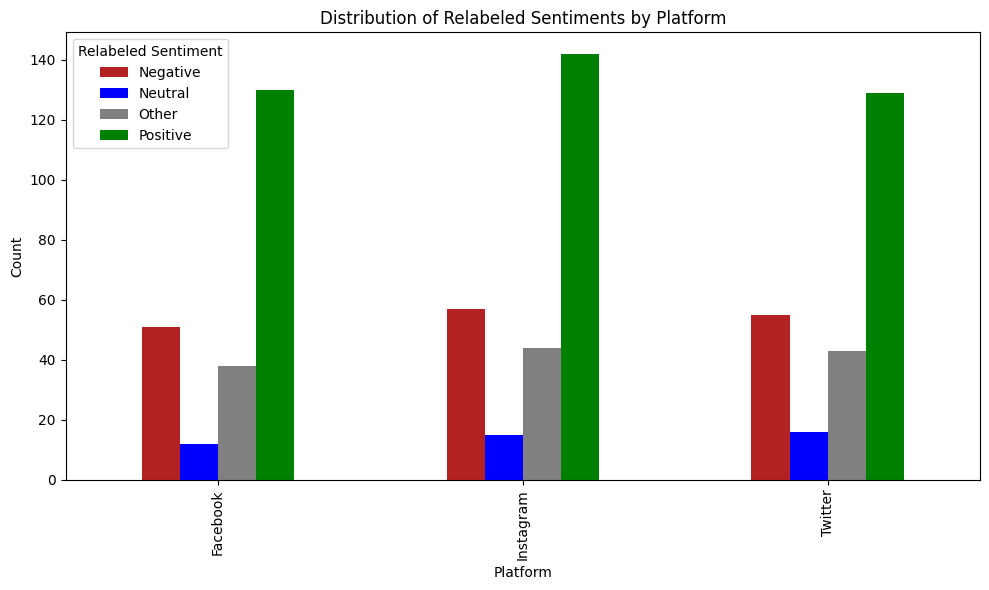

In [66]:
colors = {
    'Positive': 'green',
    'Negative': 'firebrick',
    'Neutral': 'blue',
    'Other':'grey'
}

df.plot(kind='bar', stacked=False, figsize=(10, 6), color = colors)

# Adicionar títulos e rótulos
plt.title('Distribution of Relabeled Sentiments by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(title='Relabeled Sentiment')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [68]:
platform_sentiment = data_tmp.groupby(['Country','Relabeled_Sentiment']).size().reset_index(name='Count')
df = platform_sentiment.pivot_table(index = 'Country', columns = 'Relabeled_Sentiment', values = 'Count', fill_value = 0)
df = df.div(df.sum(axis=0), axis=1)*100
df

Relabeled_Sentiment,Negative,Neutral,Other,Positive
Country,,,,
australia,13.496933,9.302326,7.2,9.975062
austria,0.000000,0.000000,0.0,0.498753
belgium,0.000000,0.000000,0.8,0.249377
brazil,3.680982,0.000000,0.8,2.493766
cambodia,0.000000,0.000000,0.0,0.249377
canada,19.631902,23.255814,14.4,18.703242
china,0.000000,0.000000,0.0,0.249377
colombia,0.000000,0.000000,0.8,0.000000
czechrepublic,0.000000,0.000000,0.0,0.498753


In [69]:
platform_sentiment = data_tmp.groupby(['Country','Relabeled_Sentiment']).size().reset_index(name='Count')
df = platform_sentiment.pivot_table(index = 'Country', columns = 'Relabeled_Sentiment', values = 'Count', fill_value = 0)
df = df.div(df.sum(axis=1), axis=0)*100
df.sort_values('Negative', ascending = False)

Relabeled_Sentiment,Negative,Neutral,Other,Positive
Country,,,,
spain,66.666667,0.000000,0.000000,33.333333
germany,35.714286,7.142857,21.428571,35.714286
brazil,35.294118,0.000000,5.882353,58.823529
southafrica,33.333333,0.000000,16.666667,50.000000
france,31.250000,6.250000,31.250000,31.250000
australia,29.333333,5.333333,12.000000,53.333333
india,27.142857,8.571429,15.714286,48.571429
japan,26.666667,0.000000,33.333333,40.000000
netherlands,25.000000,0.000000,0.000000,75.000000


,Retweets,Likes
Retweets,1.000000,0.998482
Likes,0.998482,1.000000


[]

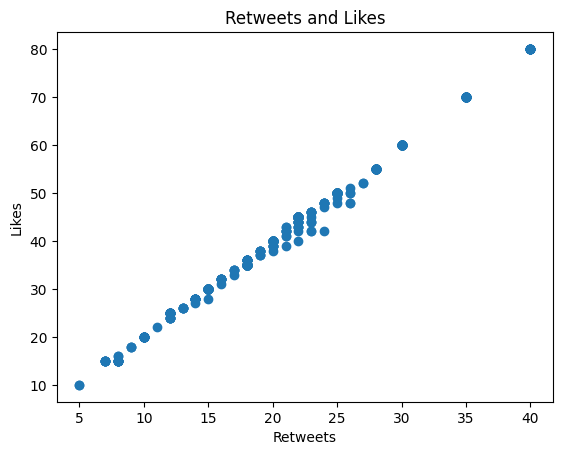

In [70]:
# Retweets and Likes

display(data_tmp[['Retweets', 'Likes']].corr())

plt.scatter(data_tmp['Retweets'], data_tmp['Likes'])
plt.title('Retweets and Likes')
plt.xlabel('Retweets')
plt.ylabel('Likes')

plt.plot()

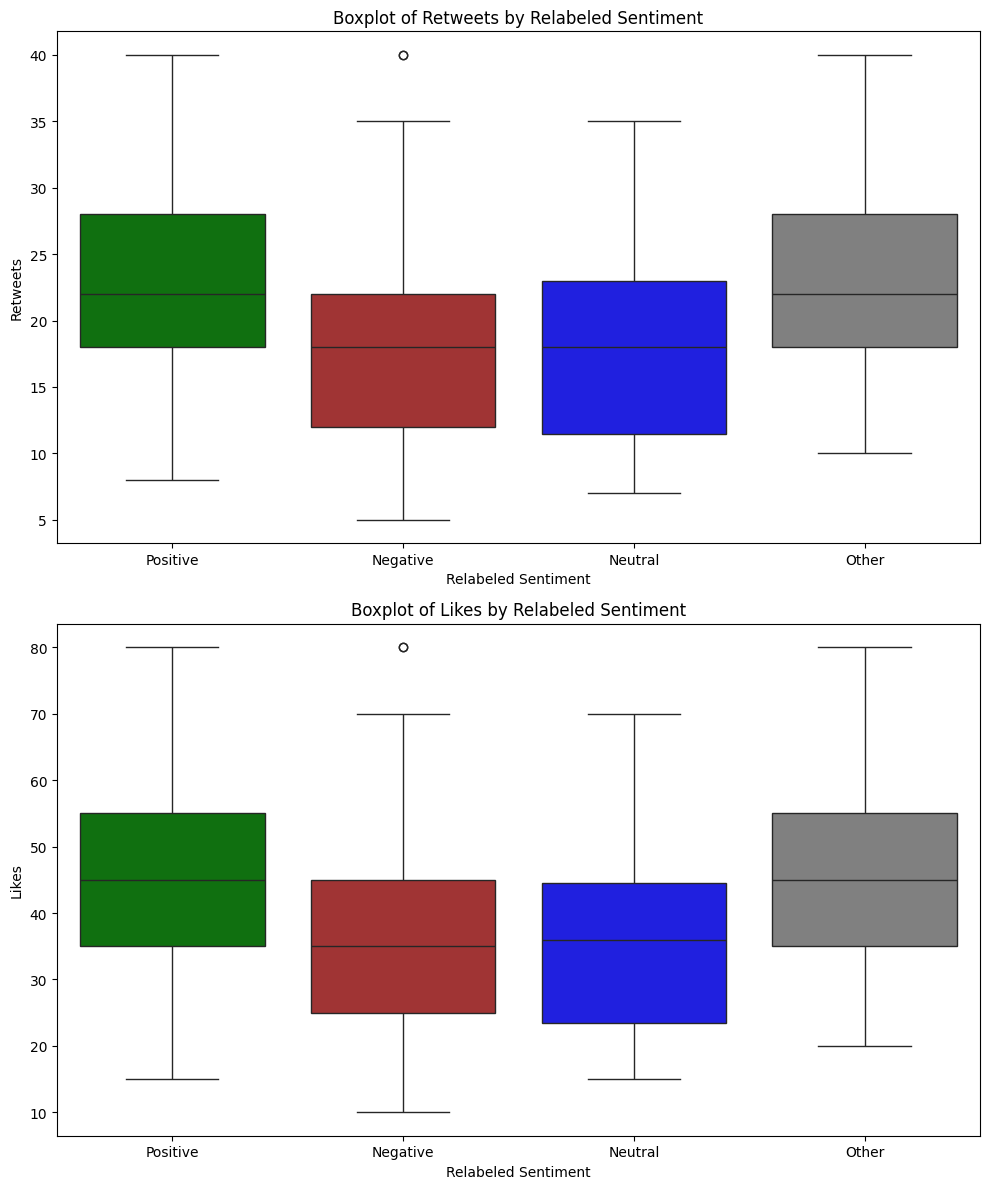

In [71]:
colors = {
    'Positive': 'green',
    'Negative': 'firebrick',
    'Neutral': 'blue',
    'Other': 'grey'
}

# Criar subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Boxplot para Retweets por Relabeled_Sentiment
sns.boxplot(x='Relabeled_Sentiment', y='Retweets', data=data_tmp, ax=axes[0], palette=colors)
axes[0].set_title('Boxplot of Retweets by Relabeled Sentiment')
axes[0].set_xlabel('Relabeled Sentiment')
axes[0].set_ylabel('Retweets')

# Boxplot para Likes por Relabeled_Sentiment
sns.boxplot(x='Relabeled_Sentiment', y='Likes', data=data_tmp, ax=axes[1], palette=colors)
axes[1].set_title('Boxplot of Likes by Relabeled Sentiment')
axes[1].set_xlabel('Relabeled Sentiment')
axes[1].set_ylabel('Likes')

# Ajustar layout
plt.tight_layout()
plt.show()

In [73]:
test_means_difference(data_tmp, 'Retweets', 'Relabeled_Sentiment')

Normalidade dos dados:
Negative: p-value = 0.0005
Neutral: p-value = 0.1062
Other: p-value = 0.0009
Positive: p-value = 0.0000

Resultado do teste (Kruskal-Wallis):
Estatística do teste: 65.6708
p-valor: 0.0000
Conclusão: As médias dos grupos são significativamente diferentes.


{'test_name': 'Kruskal-Wallis',
 'test_statistic': 65.67083050079088,
 'p_value': 3.6045830363625846e-14,
 'conclusion': 'As médias dos grupos são significativamente diferentes.'}

In [74]:
test_means_difference(data_tmp, 'Likes', 'Relabeled_Sentiment')

Normalidade dos dados:
Negative: p-value = 0.0004
Neutral: p-value = 0.1032
Other: p-value = 0.0018
Positive: p-value = 0.0000

Resultado do teste (Kruskal-Wallis):
Estatística do teste: 65.5831
p-valor: 0.0000
Conclusão: As médias dos grupos são significativamente diferentes.


{'test_name': 'Kruskal-Wallis',
 'test_statistic': 65.58307704738213,
 'p_value': 3.7638175581552795e-14,
 'conclusion': 'As médias dos grupos são significativamente diferentes.'}

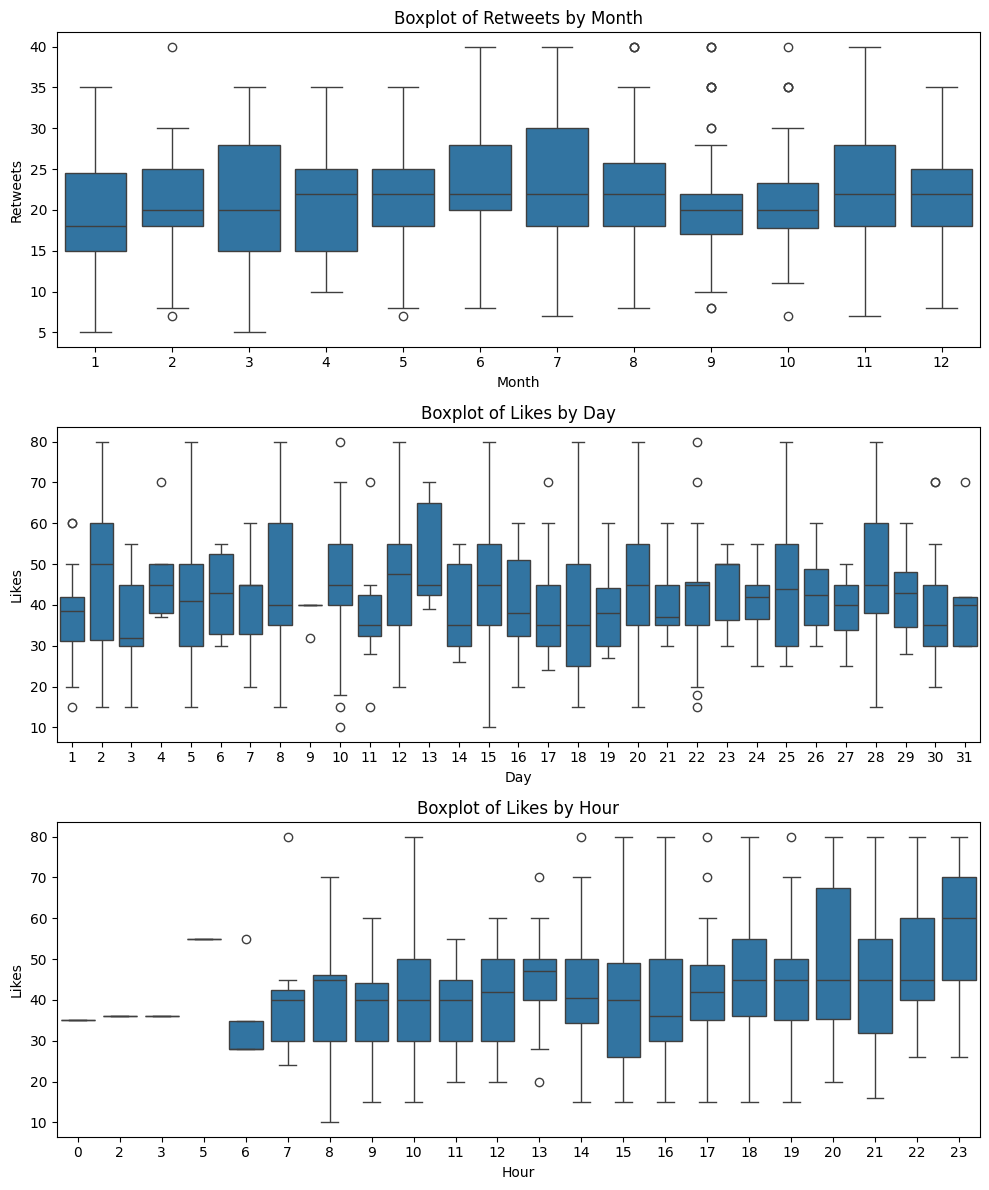

In [75]:
# Month

# Criar subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Boxplot para Retweets por Relabeled_Sentiment
sns.boxplot(x='Month', y='Retweets', data=data_tmp, ax=axes[0])
axes[0].set_title('Boxplot of Retweets by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Retweets')

# Boxplot para Likes por Relabeled_Sentiment
sns.boxplot(x='Day', y='Likes', data=data_tmp, ax=axes[1])
axes[1].set_title('Boxplot of Likes by Day')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Likes')

# Boxplot para Likes por Relabeled_Sentiment
sns.boxplot(x='Hour', y='Likes', data=data_tmp, ax=axes[2])
axes[2].set_title('Boxplot of Likes by Hour')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Likes')


# Ajustar layout
plt.tight_layout()
plt.show()

## DATA PREPARATION

In [147]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack


from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

- It is important to notice that the variables Text and Hashtags were cleaned in the EDA process. This means that I removed the punctuation, converted the words to lowercase, and removed the stopwords.

In [101]:
data_text = data_tmp[['cleaned_text', 'Hashtags', 'Relabeled_Sentiment']].copy()

In [102]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_text[['cleaned_text', 'Hashtags']], data_text['Relabeled_Sentiment'], test_size=0.2, random_state=42)

In [103]:
# Feature extraction for text and hashtags
text_vectorizer = TfidfVectorizer(max_features=5000)
hashtag_vectorizer = TfidfVectorizer(max_features=1000)

In [106]:
X_train_text = text_vectorizer.fit_transform(X_train['cleaned_text'])
X_train_hashtags = hashtag_vectorizer.fit_transform(X_train['Hashtags'])

X_test_text = text_vectorizer.transform(X_test['cleaned_text'])
X_test_hashtags = hashtag_vectorizer.transform(X_test['Hashtags'])

# Combine features
X_train_combined = hstack([X_train_text, X_train_hashtags])
X_test_combined = hstack([X_test_text, X_test_hashtags])

## Logistic Regression

In [112]:
# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

# Evaluate the model
y_pred_log = model.predict(X_test_combined)
accuracy_logistic = accuracy_score(y_test, y_pred_log)
classification_rep_logistic = classification_report(y_test, y_pred_log)

In [113]:
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logistic}")
print("Classification Report:\n", classification_rep_logistic)

Logistic Regression Results:
Accuracy: 0.7414965986394558
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.69      0.81        42
     Neutral       1.00      0.40      0.57         5
       Other       1.00      0.27      0.42        30
    Positive       0.65      1.00      0.79        70

    accuracy                           0.74       147
   macro avg       0.91      0.59      0.65       147
weighted avg       0.83      0.74      0.71       147



In [120]:
# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(X_train_combined, y_train)

# Evaluate the model
y_pred_log = model.predict(X_test_combined)
accuracy_logistic = accuracy_score(y_test, y_pred_log)
classification_rep_logistic = classification_report(y_test, y_pred_log)

In [121]:
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logistic}")
print("Classification Report:\n", classification_rep_logistic)

Logistic Regression Results:
Accuracy: 0.8231292517006803
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.81      0.88        42
     Neutral       0.80      0.80      0.80         5
       Other       0.93      0.43      0.59        30
    Positive       0.75      1.00      0.86        70

    accuracy                           0.82       147
   macro avg       0.86      0.76      0.78       147
weighted avg       0.85      0.82      0.81       147



## Naive Bayes

In [124]:
# Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_combined, y_train)

# Evaluate the model
y_pred_naiv = model.predict(X_test_combined)
accuracy_naive = accuracy_score(y_test, y_pred_naiv)
classification_rep_naive = classification_report(y_test, y_pred_naiv)

In [151]:
print("Naive Bayes Results:")
print(f"Accuracy: {accuracy_naive}")
print("Classification Report:\n", classification_rep_naive)

Naive Bayes Results:
Accuracy: 0.7619047619047619
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.76      0.83        42
     Neutral       1.00      0.20      0.33         5
       Other       1.00      0.30      0.46        30
    Positive       0.69      1.00      0.81        70

    accuracy                           0.76       147
   macro avg       0.90      0.57      0.61       147
weighted avg       0.83      0.76      0.73       147



## SVM

In [133]:
## SVM

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_combined, y_train)

# Evaluate the SVM model
svm_y_pred = svm_model.predict(X_test_combined)
accuracy_svm = accuracy_score(y_test, svm_y_pred)
classification_rep_svm = classification_report(y_test, svm_y_pred)

In [152]:
print("SVM Results:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:\n", classification_rep_svm)

SVM Results:
Accuracy: 0.7959183673469388
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.81      0.88        42
     Neutral       0.75      0.60      0.67         5
       Other       1.00      0.33      0.50        30
    Positive       0.71      1.00      0.83        70

    accuracy                           0.80       147
   macro avg       0.86      0.69      0.72       147
weighted avg       0.85      0.80      0.77       147



In [137]:
## SVM balanced

# Train the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_combined, y_train)

# Evaluate the SVM model
svm_bal_y_pred = svm_model.predict(X_test_combined)
accuracy_svm_bal = accuracy_score(y_test, svm_bal_y_pred)
classification_rep_svm_bal = classification_report(y_test, svm_bal_y_pred)

In [153]:
print("SVM Balanced Results:")
print(f"Accuracy: {accuracy_svm_bal}")
print("Classification Report:\n", classification_rep_svm_bal)

SVM Balanced Results:
Accuracy: 0.7959183673469388
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.81      0.88        42
     Neutral       0.75      0.60      0.67         5
       Other       1.00      0.33      0.50        30
    Positive       0.71      1.00      0.83        70

    accuracy                           0.80       147
   macro avg       0.86      0.69      0.72       147
weighted avg       0.85      0.80      0.77       147



# Random Forest

In [141]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_combined, y_train)

# Evaluate the Random Forest model
rf_y_pred = rf_model.predict(X_test_combined)
accuracy_rf = accuracy_score(y_test, rf_y_pred)
classification_rf = classification_report(y_test, svm_y_pred)

In [154]:
print("Random Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:\n", classification_rf)

Random Forest Results:
Accuracy: 0.6938775510204082
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.81      0.88        42
     Neutral       0.75      0.60      0.67         5
       Other       1.00      0.33      0.50        30
    Positive       0.71      1.00      0.83        70

    accuracy                           0.80       147
   macro avg       0.86      0.69      0.72       147
weighted avg       0.85      0.80      0.77       147



## Gradient Boosting

In [145]:
## Gradient Boosting

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train_combined, y_train)

# Evaluate the Gradient Boosting model
gb_y_pred = gb_model.predict(X_test_combined)
accuracy_gb = accuracy_score(y_test, gb_y_pred)
classification_gb = classification_report(y_test, gb_y_pred)

In [155]:
print("Gradient Boosting Results:")
print(f"Accuracy: {accuracy_gb}")
print("Classification Report:\n", classification_gb)

Gradient Boosting Results:
Accuracy: 0.3469387755102041
Classification Report:
               precision    recall  f1-score   support

    Negative       0.32      0.79      0.45        42
     Neutral       0.19      0.80      0.31         5
       Other       0.00      0.00      0.00        30
    Positive       0.88      0.20      0.33        70

    accuracy                           0.35       147
   macro avg       0.35      0.45      0.27       147
weighted avg       0.51      0.35      0.29       147



In [150]:
# Train the Gradient Boosting model with class weight adjustment
# Convert sparse matrices to dense arrays
X_train_combined_dense = X_train_combined.toarray()
X_test_combined_dense = X_test_combined.toarray()

# Train the Gradient Boosting model with class weight adjustment
gb_model = HistGradientBoostingClassifier(max_iter=100, class_weight='balanced')
gb_model.fit(X_train_combined_dense, y_train)

# Evaluate the Gradient Boosting model
gb_bal_y_pred = gb_model.predict(X_test_combined_dense)
accuracy_gb = accuracy_score(y_test, gb_bal_y_pred)
classification_gb = classification_report(y_test, gb_bal_y_pred)

# Print evaluation results
print('Gradient Boosting Results:')
print(f'Accuracy: {accuracy_gb:.2f}')
print(classification_gb)

Accuracy: 0.35
Classification Report:
              precision    recall  f1-score   support

    Negative       0.32      0.79      0.45        42
     Neutral       0.19      0.80      0.31         5
       Other       0.00      0.00      0.00        30
    Positive       0.88      0.20      0.33        70

    accuracy                           0.35       147
   macro avg       0.35      0.45      0.27       147
weighted avg       0.51      0.35      0.29       147

